# Session 08. 지도학습2

# ★퀘스트★

### 오늘 배운 모델들을 활용하여 (DT, SVM, XGBOOST / RF는 제외!!) 이보다 더 정교한 모델을 만들어보아요.
### 목표는 정확도 > 63%

(+추가)
같은 모델이더라도, 하이퍼 파라미터를 바꿔가며 코드를 실행해보면 결과가 달라집니다. 예를 들어 RF에서 나무의 개수!

또는 모델에 들어갈 x 변수를 더 늘리거나 줄여도 성능이 달라집니다.

time 모듈을 활용하여 각 모델별로 걸리는 시간도 측정해보세요.

모르는 게 있으면 질문해주세요!

In [0]:
 import numpy as np 
import pandas as pd 
import os

In [0]:
df = pd.read_csv("AB_NYC_2019.csv")

뉴욕의 에어비엔비 데이터셋을 활용하여 방 타입, 숙박 가격, 최소숙박일수, 최근리뷰, 월 리뷰갯수 등으로부터 숙소의 위치를 알아내는 모델

편의상 맨하튼, 브루클린의 숙소들로 범위를 좁혔습니다

In [0]:
# 브루클린, 맨하튼 숙소만 해볼거니까 이거만 추림
our_set = df[df['neighbourhood_group'].isin(['Brooklyn', 'Manhattan'])]
df.shape, our_set.shape,

((48895, 16), (41765, 16))

In [0]:
onehot = pd.get_dummies(our_set['room_type'])

In [0]:
# 핵심 컬럼만 뽑음 + 더미변수까지 결합
core_cols = our_set[['neighbourhood_group', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']]
combined = core_cols.merge(onehot, left_index=True, right_index=True, how='left').reset_index()
combined.head()

,index,neighbourhood_group,price,minimum_nights,number_of_reviews,reviews_per_month,Entire home/apt,Private room,Shared room
0,0,Brooklyn,149,1,9,0.21,0,1,0
1,1,Manhattan,225,1,45,0.38,1,0,0
2,2,Manhattan,150,3,0,NaN,0,1,0
3,3,Brooklyn,89,1,270,4.64,1,0,0
4,4,Manhattan,80,10,9,0.10,1,0,0


###  결측치 제외

In [0]:
final = combined.drop(columns=['index']).dropna() # 인덱스가 중복되어있으므로 버리고, 편의상 na도 다 버림
final.shape

(33079, 8)

### 예측을 위해 Brooklyn = 0 / Manhattan = 1 로 인코딩

In [0]:
final = final.replace('Brooklyn', 0).replace('Manhattan', 1)  # brooklyn은 0, manhattan은 1로 바꿈

### 최종 데이터프레임

In [0]:
final.head()

,neighbourhood_group,price,minimum_nights,number_of_reviews,reviews_per_month,Entire home/apt,Private room,Shared room
0,0,149,1,9,0.21,0,1,0
1,1,225,1,45,0.38,1,0,0
3,0,89,1,270,4.64,1,0,0
4,1,80,10,9,0.10,1,0,0
5,1,200,3,74,0.59,1,0,0


In [0]:
bk = len(final[final['neighbourhood_group']==0])
mh = len(final[final['neighbourhood_group']==1])
tt = len(final)
print(bk, mh, tt) # 브루클린 건은 16447, 맨하탄 건은 16632건, 총 33079건

16447 16632 33079


# XGBOOST

In [0]:
import random
random_seed = 777

In [0]:
### 랜덤 시드를 활용하여 트레인, 테스트셋 분리 / 3:1 비율로

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']], final['neighbourhood_group'], 
                                                    test_size=0.25, random_state=random_seed)

In [0]:
import matplotlib.pyplot as plt

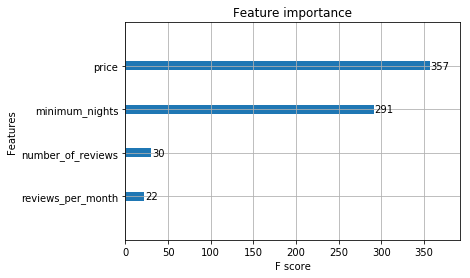

In [0]:
### 랜덤포레스트 모델 수립, 대충 하이퍼 파라미터 제공
import time
from xgboost import XGBClassifier
from xgboost import plot_importance
#from matplotlib import pyplot

model = XGBClassifier(random_state=777,learning_rate=0.01)
#hyper parameter 지정
model.fit(X_train,y_train)
#변수중요도 파악
plot_importance(model)
plt.show()

In [0]:
from sklearn.metrics import accuracy_score

### 학습된 모델로 분류 예측
prediction = model.predict(X_test)
### 채점
accuracy = accuracy_score(y_test, prediction)
### 성적 발표
print(f'Mean accuracy score: {100*accuracy:.5}%')

Mean accuracy score: 63.035%


## Accuracy 향상을 위해 hyperparameter 수정
- learning rate=0.03~0.3 사이
- iteration =50으로 설정해서 충분히 학습할 수 있도록 함

In [0]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [0]:
from scipy.stats import uniform, randint
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split


model = XGBClassifier(random_state=777,learning_rate=0.01)

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(model, param_distributions=params, 
                            random_state=777, n_iter=50, cv=3, 
                            verbose=2, n_jobs=1, return_train_score=True)

search.fit(X_train, y_train)




In [0]:
#63.9%의 정확도를 보인다
report_best_scores(search.cv_results_, 1)

Model with rank: 1
Mean validation score: 0.639 (std: 0.002)
Parameters: {'colsample_bytree': 0.8199331948681519, 'gamma': 0.25908672751884204, 'learning_rate': 0.032216535259166984, 'max_depth': 4, 'n_estimators': 129, 'subsample': 0.9417884782405052}



## DT model

In [0]:
from sklearn.tree import DecisionTreeClassifier

# data split(random_state는 셔플을 위한 랜덤 시드)
clf = DecisionTreeClassifier(max_depth = 4, random_state = 777)
# modeling
clf.fit(X_train,y_train)

print('train set score {:3f}'.format(clf.score(X_train,y_train)))
print('test set score {:3f}'.format(clf.score(X_test,y_test)))

train set score 0.632230
test set score 0.630230


In [0]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifier
# VotingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_validate

models = [
    ('rfc', RandomForestClassifier()),   #위에서 튜닝(..)한 dt모델
    ('knn', KNeighborsClassifier()),
    ('xgb', model), #위에서 튜닝한 xgb model
    ('dtc', clf),
]

# soft vote
soft_vote  = VotingClassifier(models, voting='soft')
soft_vote_cv = cross_validate(soft_vote, X_train, y_train)
soft_vote.fit(X_train, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py

VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators='warn',
                                                     n_jobs=None,
      

In [0]:
# Accuracy
print('train set score {:3f}'.format(soft_vote.score(X_train,y_train)))
print('test set score {:3f}'.format(soft_vote.score(X_test,y_test)))

train set score 0.854932
test set score 0.626965


- overfitting이 제대로 났다...
- -> ensemble 계속 수정해도 overfitting이 고쳐지지 않아 제출합니다
- kfold cross val 같이 validation set 해도 될 것 같네요

### refer
- random forest를 제외한 대부분의 ensemble 모형은 원리적으로는 여러 종류의 다양한 classifier를 사용해도 되지만 구현 및 사용 편의상 한가지만 구현하는 것이 보통입니다. 특히 boosting 종류에서는 overfitting이 되기 쉽기 때문에 kernelSVN등의 성능이 좋은(strong) classfiier 보다는 KNN 등 성능이 떨어지지만 계산량이 적은 classifier를 많이 사용합니다.
- https://datascienceschool.net/view-notebook/766fe73c5c46424ca65329a9557d0918/

In [0]:

hard_vote  = VotingClassifier(models, voting='hard')
hard_vote_cv = cross_validate(hard_vote, X_train, y_train)
hard_vote.fit(X_train, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py

VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators='warn',
                                                     n_jobs=None,
      

In [0]:
# Accuracy
print('train set score {:3f}'.format(hard_vote.score(X_train,y_train)))
print('test set score {:3f}'.format(hard_vote.score(X_test,y_test)))

train set score 0.767867
test set score 0.630109


In [0]:
#혹시나 해서 hard voting도 해봤는데 의미가 없네용